In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras import models, layers
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [53]:
cpus = tf.config.experimental.list_physical_devices('CPU')

In [54]:
len(cpus)

1

In [5]:
# Avoid OOM errors by setting GPU memory consumption growth
cpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in cpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [55]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [56]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Taro Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 546 files belonging to 2 classes.


In [57]:
class_names = dataset.class_names
class_names

['taro_healthy', 'taro_leaf_blight']

In [58]:
len(dataset)

18

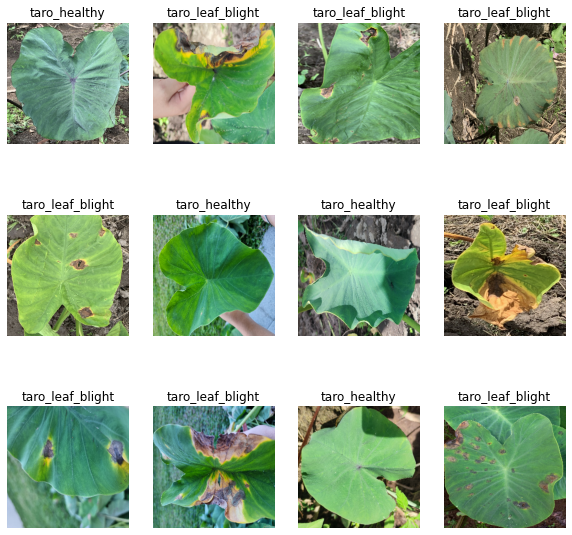

In [59]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [60]:
len(dataset)

18

In [61]:
train_size = 0.8
len(dataset)*train_size

14.4

In [62]:
train_ds = dataset.take(14)
len(train_ds)

14

In [63]:
test_ds = dataset.skip(14)
len(test_ds)

4

In [64]:
val_size = 0.1
len(dataset)*val_size

1.8

In [65]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [66]:
test_ds = test_ds.skip(1)
len(test_ds)

3

In [67]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
   
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [68]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [69]:
len(train_ds)

14

In [70]:
len(val_ds)

1

In [71]:
len(test_ds)

3

In [72]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [73]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [74]:
data_augmentation = tf.keras.Sequential ([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [75]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = keras.Sequential([
   
    #first cnn layer
    keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (input_shape)),
    keras.layers.MaxPooling2D((2,2)),
    
    #second cnn layer
    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    #third cnn layer
    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    #fourth cnn layer
    keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    #fifth cnn layer
    keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    #fully connected layer
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = "relu" ),
    keras.layers.Dense(64, activation = "softmax"),
])

model.build(input_shape = input_shape)

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)      

In [77]:
model.compile(
            optimizer = 'adam',
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = ['accuracy']
            
) 

In [78]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


C:\Users\Acer\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/14 [==============================] - 43s 3s/step - loss: 5.1457 - accuracy: 0.4689 - val_loss: 0.6598 - val_accuracy: 0.7188
Epoch 2/50
14/14 [==============================] - 24s 2s/step - loss: 0.6758 - accuracy: 0.7727 - val_loss: 0.3717 - val_accuracy: 0.8750
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 0.4486 - accuracy: 0.7919 - val_loss: 0.3026 - val_accuracy: 0.8438
Epoch 4/50
14/14 [==============================] - 24s 2s/step - loss: 0.2881 - accuracy: 0.8684 - val_loss: 0.2615 - val_accuracy: 0.9688
Epoch 5/50
14/14 [==============================] - 28s 2s/step - loss: 0.2699 - accuracy: 0.8852 - val_loss: 0.2023 - val_accuracy: 0.9375
Epoch 6/50
14/14 [==============================] - 26s 2s/step - loss: 0.2299 - accuracy: 0.8995 - val_loss: 0.1625 - val_accuracy: 0.9688
Epoch 7/50
14/14 [==============================] - 25s 2s/step - loss: 0.2616 - accuracy: 0.8923 - val_loss: 0.0875 - val_accuracy: 0.9688
Epoch 8/50
14/14 [=============

In [80]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 2s 551ms/step - loss: 0.1404 - accuracy: 0.9688


In [39]:
scores

[0.11641913652420044, 0.96875]

In [40]:
history

In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 14}

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

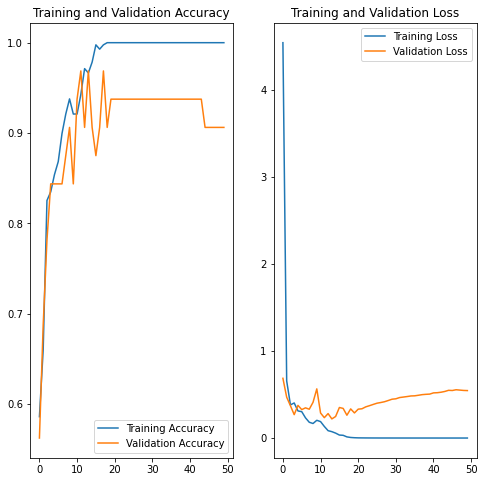

In [44]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
np.argmax([2.0516490e-10 1.0000000e+00 8.9141655e-29 2.3464512e-25 8.7639054e-25
 1.4739571e-23 2.5001452e-20 3.2699355e-27 9.2791834e-34 4.6980505e-34
 1.9691834e-17 4.3650573e-18 4.6899475e-23 6.7538946e-35 2.9982410e-31
 4.4281163e-26 7.1852760e-31 5.0811213e-19 9.9252203e-36 5.4370372e-21
 5.1543914e-33 1.8078257e-30 1.9753030e-29 2.5015112e-26 5.0033537e-28
 2.3991647e-14 9.6359821e-20 6.1838157e-34 2.8957382e-30 6.6987491e-29
 1.0543355e-28 5.2370754e-27 8.1408142e-36 1.6391837e-29 6.2471606e-29
 1.9994514e-19 2.1915691e-31 5.7271144e-24 9.5566769e-23 3.0001371e-33
 9.3175718e-32 9.7146897e-31 5.6673119e-29 3.3988159e-22 1.1787483e-27
 1.9499030e-27 4.0233556e-23 9.1210324e-22 4.7147770e-29 3.2560724e-25
 4.5502458e-25 2.4415151e-25 4.1428742e-24 2.0159032e-33 3.7062983e-34
 1.6015614e-35 2.2352000e-19 1.0878207e-35 6.8889165e-20 1.2911290e-28
 1.9122165e-28 1.5960197e-25 1.8952463e-34 3.2780283e-27])

first image to predict
actual label: taro_leaf_blight
1/1 [==============================] - 1s 838ms/step
predicted label: taro_leaf_blight


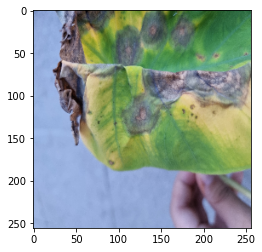

In [46]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[19].numpy().astype('uint8')
    first_label = labels_batch[19].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])
    
    

In [47]:
 def predict(model, img):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array - tf.expand_dims(img_array, 0) #Create a batch
        
        predictions = model.predict(img_array)
        
        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        return predicted_class, confidence

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/conv2d/Relu' defined at (most recent call last):
    File "C:\Users\Acer\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Acer\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Acer\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Acer\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Acer\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Acer\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Acer\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Acer\AppData\Local\Temp\ipykernel_4872\2514123125.py", line 7, in <cell line: 2>
      predicted_class, confidence = predict(model, images[i].numpy())
    File "C:\Users\Acer\AppData\Local\Temp\ipykernel_4872\4186884293.py", line 5, in predict
      predictions = model.predict(img_array)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\Acer\anaconda3\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_2/conv2d/Relu'
input must be 4-dimensional[32,256,3]
	 [[{{node sequential_2/conv2d/Relu}}]] [Op:__inference_predict_function_6123]

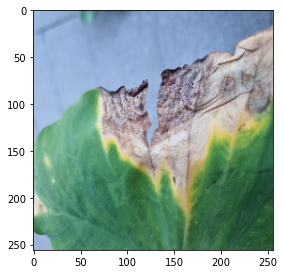

In [48]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_nams[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")
        

In [50]:
model_version=2
model.save(f"...models/{model_version}")

INFO:tensorflow:Assets written to: ...models/2\assets


INFO:tensorflow:Assets written to: ...models/2\assets
